# Wallstreetbets data (Kaggle) EDA

### Parent Directory Configurations 

**Notebook note:** Please make sure that the `PATH` of this notebook corresponds to the base-directory path of this repository. 
This will ensure that all executions, data reading will have the reference as if this notebook were in the base directory; 
otherwise, you might need to change the PATH and do some trickery (which is a pain for Jupyter notebooks) 

In [1]:
# verify working directory of the notebook 
import os 
print(os.getcwd())

c:\Users\jairp\OneDrive\Desktop_remote\HEC Montreal\3. Winter 2024\Machine Learning I\WallstreetbetsGenNLP


## Imports 

In [22]:
# General imports
import pprint 
import zipfile 
import logging
from collections import Counter
from typing import Union, List 
from tqdm.notebook import tqdm 

# Data Analysis and visualizations
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter

# NLTK setup
import nltk 
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Text Processing 
import re 
import spacy
import gensim
from gensim import corpora
from emoji import demojize
from spacy.tokens import Doc
from nltk.corpus import stopwords
from gensim.models.callbacks import PerplexityMetric
from gensim.models.phrases import ENGLISH_CONNECTOR_WORDS

# Dedicated NLP Visualizations 
import pyLDAvis
import pyLDAvis.gensim
from wordcloud import WordCloud

# Custom scripts 
from src.utils import format_topics_sentences
from src.utils import plot_topic_keywords

# Configurations 
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# Exclude common negation words from the stop words list
# negation_words = {'no', 'not', 'nor', 'neither', 'never', "n't", 'none', 'through'}
except_words = {'through'}
stop_words = stop_words - except_words

# Load Spacy model and disable irrelevant components for acceleration
nlp = spacy.load("en_core_web_md", disable=["parser", "ner"])
# nlp.max_length = 1500000  # Adjust based on your text size

# Set pprint options with indent 4
pprint = pprint.PrettyPrinter(indent=4).pprint

# Ignore warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Data Loading 

### Extracting the data 

Here, we want to extract and preview the data 

In [3]:
# Specify the path to the zip files
zip_file_path = 'data_raw/reddit_wsb.csv.zip'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('data_raw')

# Read the CSV using Pandas
csv_file_path = 'data_raw/reddit_wsb.csv'
df = pd.read_csv(csv_file_path)

# Fill all the NaN values in the body column with an empty string
df['body'] = df['body'].fillna('')

# Combine the title and bodyy into a single column text, separated by two newlines
df['text'] = df['title'] + '\n\n' + df['body']

# drop the body column 
df = df.drop(columns=['body'])

# Preview the loaded data 
display(df.head(40))

,title,score,id,url,comms_num,created,timestamp,text
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,2021-01-28 21:37:41,"It's not about the money, it's about sending a..."
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,2021-01-28 21:32:10,Math Professor Scott Steiner says the numbers ...
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,2021-01-28 21:30:35,Exit the system\n\nThe CEO of NASDAQ pushed to...
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,2021-01-28 21:28:57,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC..."
5,WE BREAKING THROUGH,405,l6uf7d,https://i.redd.it/2wef8tc062e61.png,84,1.611862e+09,2021-01-28 21:26:30,WE BREAKING THROUGH\n\n
6,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE,317,l6uf6d,https://www.reddit.com/r/wallstreetbets/commen...,53,1.611862e+09,2021-01-28 21:26:27,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE\n\...
7,THIS IS THE MOMENT,405,l6ub9l,https://www.reddit.com/r/wallstreetbets/commen...,178,1.611862e+09,2021-01-28 21:19:31,THIS IS THE MOMENT\n\nLife isn't fair. My moth...
8,Currently Holding AMC and NOK - Is it retarded...,200,l6ub4i,https://i.redd.it/6k2z7ouo42e61.png,161,1.611862e+09,2021-01-28 21:19:16,Currently Holding AMC and NOK - Is it retarded...
9,I have nothing to say but BRUH I am speechless...,291,l6uas9,https://i.redd.it/bfzzw2yo42e61.jpg,27,1.611862e+09,2021-01-28 21:18:37,I have nothing to say but BRUH I am speechless...


In [4]:
print(df.shape)
print(df.columns)

(53187, 8)
Index(['title', 'score', 'id', 'url', 'comms_num', 'created', 'timestamp',
       'text'],
      dtype='object')


In [5]:
texts = df['text'].iloc[0:10, ].tolist()
texts

["It's not about the money, it's about sending a message. 🚀💎🙌\n\n",
 'Math Professor Scott Steiner says the numbers spell DISASTER for Gamestop shorts\n\n',
 'Exit the system\n\nThe CEO of NASDAQ pushed to halt trading “to give investors a chance to recalibrate their positions”.\n\n[https://mobile.twitter.com/Mediaite/status/1354504710695362563](https://mobile.twitter.com/Mediaite/status/1354504710695362563)\n\nNow SEC is investigating, brokers are disallowing buying more calls. This is the institutions flat out admitting they will change the rules to bail out the rich but if it happens to us, we get a “well shucks you should have known investing is risky! have you tried cutting out avocados and coffee, maybe doing Uber on the side?”\n\nWe may have collectively driven up enough sentiment in wall street to make other big players go long on GME with us (we do not have the money to move the stock as much as it did alone). we didn’t hurt wall street as a whole, just a few funds went down w

### Text Cleaning (for Clustering)

In [6]:
def clean_text(texts: Union[str, List[str], pd.Series], clean_emojis: bool = False) -> Union[str, List[str]]:
    """
    Clean and preprocess text data for topic modeling.

    This function performs several preprocessing steps on a list of text documents:
    - Removes hyperlinks.
    - Tokenizes and lemmatizes the text using spaCy.
    - Converts and cleans emojis.
    - Removes non-alphabetic characters, stopwords, and short tokens.
    - Filters out verbs to reduce noise.
    - Forms bigrams and trigrams, filtering out those containing stopwords or non-alphabetic characters.
    - Splits n-grams longer than 4 into individual tokens.

    Parameters:
    - texts: A list of text documents to be cleaned.
    - clean_emojis: A boolean indicating whether emojis should be removed from the text.

    Returns:
    - A list of cleaned text documents, with each document represented as a list of tokens.
    """

    # Preprocess the texts to remove hyperlinks
    texts = [re.sub(r'http\S+|www\S+|ftp\S+', '', text) for text in texts]

    # Define a function to clean a single document
    def clean_doc(doc: Doc, clean_emojis: bool = False) -> List[str]:
        # Filter out tokens that are stopwords, verbs, or have length less than 2, then lemmatize and lowercase
        tokens = [demojize(token.lemma_ if token.lemma_ != '-PRON-' else token.text).lower() for token in doc
                  if not (token.is_stop or token.pos_ == 'VERB' or len(token.text) < 2)]

        # Convert and clean emojis
        tokens = [re.sub(r':', '_', token) if token.startswith(':') and token.endswith(':') else token for token in tokens]
        if clean_emojis:
            tokens = [re.sub(r'_.*_', '', token) for token in tokens]

        # Remove non-alphabetic characters except for '_'
        tokens = [re.sub(r'[^a-z_]', '', token) for token in tokens]

        return tokens

    # Apply the cleaning function to each document
    cleaned_texts = [clean_doc(doc, clean_emojis) for doc in tqdm(nlp.pipe(texts, batch_size=50), total=len(texts), desc="Cleaning Texts")]

    # Form bigrams and trigrams
    bigram_mod = gensim.models.phrases.Phraser(gensim.models.Phrases(cleaned_texts, min_count=3, threshold=10, connector_words=ENGLISH_CONNECTOR_WORDS))
    trigram_mod = gensim.models.phrases.Phraser(gensim.models.Phrases(bigram_mod[cleaned_texts], threshold=10, connector_words=ENGLISH_CONNECTOR_WORDS))
    cleaned_texts = [bigram_mod[doc] for doc in tqdm(cleaned_texts, desc="Creating bigrams...")]
    cleaned_texts = [trigram_mod[bigram_mod[doc]] for doc in tqdm(cleaned_texts, desc="Creating trigrams...")]

    # Filter out bigrams and trigrams containing stopwords or non-alphabetic characters, and split n-grams longer than 4
    cleaned_texts = [[token for sub_token in doc for token in 
                      (sub_token.split('_') if len(sub_token.split('_')) > 4 else [sub_token])
                      if all(word not in stop_words and re.match('^[a-z_]+$', word) for word in token.split('_'))]
                     for doc in cleaned_texts]

    return cleaned_texts



In [7]:
# Extract all the titles from the dataframe
texts = df['text'].tolist()

# Clean the corpus
clean_texts = clean_text(texts, clean_emojis=True)

Cleaning Texts:   0%|          | 0/53187 [00:00<?, ?it/s]

Creating bigrams...:   0%|          | 0/53187 [00:00<?, ?it/s]

Creating trigrams...:   0%|          | 0/53187 [00:00<?, ?it/s]

In [8]:
# Display the cleaned corpus
for i, document in enumerate(clean_texts): 
    if i < 20: 
        print("original doc: \t", texts[i])
        print("clean doc: \t", document)
    else: 
        break

original doc: 	 It's not about the money, it's about sending a message. 🚀💎🙌


clean doc: 	 ['money', 'message']
original doc: 	 Math Professor Scott Steiner says the numbers spell DISASTER for Gamestop shorts


clean doc: 	 ['math', 'professor', 'scott', 'steiner', 'number', 'disaster', 'gamestop', 'short']
original doc: 	 Exit the system

The CEO of NASDAQ pushed to halt trading “to give investors a chance to recalibrate their positions”.

[https://mobile.twitter.com/Mediaite/status/1354504710695362563](https://mobile.twitter.com/Mediaite/status/1354504710695362563)

Now SEC is investigating, brokers are disallowing buying more calls. This is the institutions flat out admitting they will change the rules to bail out the rich but if it happens to us, we get a “well shucks you should have known investing is risky! have you tried cutting out avocados and coffee, maybe doing Uber on the side?”

We may have collectively driven up enough sentiment in wall street to make other big players go

# LDA Modelisation 



In [9]:
###############################################
### Step 1: Preparation and hyperparameters ###
###############################################

# Create a subset of randomly selected clean texts
clean_texts_subset = [clean_texts[i] for i in np.random.randint(0, len(clean_texts), max(50000, len(clean_texts)))]

# Create a dictionary mapping from word IDs to words
id2word = corpora.Dictionary(clean_texts_subset)

# Convert document into the bag-of-words (BoW) format = list of (token_id, token_count)
corpus = [id2word.doc2bow(text) for text in clean_texts_subset]

# Log the perplexity score at the end of each epoch.
perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')

# Create a dictionary with the parameters used in the LDA model 
lda_params = {
    'num_topics': 4,                 # The number of requested latent topics to be extracted from the training corpus
    'update_every': 1,               # Number of documents to be iteratively updated
    'chunksize': 100,                 # Number of documents to be used in each training chunk
    'passes': 7,                     # Number of passes through the corpus during training
    'alpha': 'symmetric',            # Hyperparameter affecting sparsity/thickness of the topics
    'iterations': 100,               # Maximum number of iterations through the corpus when inferring the topic distribution of a corpus
}

##############################
### Step 2: Model training ###
##############################

# Build LDA model with the corpus and dictionary
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,                              # Corpus to perform LDA on
    id2word=id2word,                            # Mapping from IDs to words
    num_topics=lda_params["num_topics"],        # The number of requested latent topics to be extracted from the training corpus
    random_state=100,                           # Random state for reproducibility
    update_every=lda_params["update_every"],    # Number of documents to be iteratively updated
    chunksize=lda_params["chunksize"],          # Number of documents to be used in each training chunk
    passes=lda_params["chunksize"],             # Number of passes through the corpus during training
    alpha=lda_params['alpha'],                  # Hyperparameter affecting sparsity/thickness of the topics
    iterations=lda_params["iterations"],        # Maximum number of iterations through the corpus when inferring the topic distribution of a corpus
    eval_every=10,                               # Log perplexity is estimated every that many updates
    per_word_topics=True,                       # If True, the model also computes a list of topics, sorted in descending order of most likely topics for each word
    callbacks=[perplexity_logger]               # Log the perplexity score at the end of each epoch
)

############################
### Step 3: Model saving ###
############################

# Create a directory for the model if it doesn't exist
model_dir = 'models/lda_model'
os.makedirs(model_dir, exist_ok=True)

# Generate a custom name for the model based on the parameters
model_name = f'lda_model_{lda_params["num_topics"]}_{lda_params["update_every"]}_{lda_params["chunksize"]}_{lda_params["passes"]}_{lda_params["alpha"]}_{lda_params["iterations"]}.model'

# Save the model with the custom name
model_path = os.path.join(model_dir, model_name)
lda_model.save(model_path)

# Print the Keyword in the 4 topics
pprint(lda_model.print_topics())

[   (   0,
        '0.018*"year" + 0.015*"market" + 0.015*"company" + 0.014*"stock" + '
        '0.010*"xb" + 0.009*"high" + 0.008*"time" + 0.008*"good" + '
        '0.007*"price" + 0.007*"earning"'),
    (   1,
        '0.038*"gme" + 0.017*"money" + 0.016*"people" + 0.016*"stock" + '
        '0.013*"like" + 0.012*"robinhood" + 0.010*"time" + 0.009*"amc" + '
        '0.008*"guy" + 0.007*"right"'),
    (   2,
        '0.022*"company" + 0.007*"product" + 0.007*"car" + 0.006*"new" + '
        '0.005*"business" + 0.005*"space" + 0.005*"technology" + 0.005*"ev" + '
        '0.005*"service" + 0.005*"industry"'),
    (   3,
        '0.063*"share" + 0.027*"price" + 0.022*"short" + 0.022*"stock" + '
        '0.015*"option" + 0.014*"day" + 0.012*"xb" + 0.010*"volume" + '
        '0.009*"position" + 0.008*"market"')]


In [10]:
model_name

'lda_model_4_1_100_7_symmetric_100.model'

## Load a saved LDA Model 

In [11]:
# # specify model name
# model_name = 'lda_model_6_1_50_10_symmetric_100.model'

# # Load the model
# lda_model = gensim.models.ldamodel.LdaModel.load(os.path.join(model_dir, model_name)) 


## Dominant Topic and Percentage Contribution in each Document

In [12]:
# Apply the function to the LDA model, corpus, and original texts to get the topic distribution DataFrame
df_dominant_topic = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=clean_texts_subset)

# Display the first 10 rows of the DataFrame
df_dominant_topic.head(10)

iterating through corpus...: 100%|██████████| 53187/53187 [01:39<00:00, 532.23it/s]


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2,0.5382,"company, product, car, new, business, space, t...","[minutes, air, specialized, uap, program, ahea..."
1,1,0,0.4574,"year, market, company, stock, xb, high, time, ...","[texas, march, catalyst]"
2,2,0,0.5153,"year, market, company, stock, xb, high, time, ...","[apps, price_movement, today, absolutely, kill..."
3,3,3,0.6082,"share, price, short, stock, option, day, xb, v...",[stock]
4,4,1,0.5217,"gme, money, people, stock, like, robinhood, ti...","[trading, gme, early, today]"
5,5,1,0.4617,"gme, money, people, stock, like, robinhood, ti...","[gme, share, cheap]"
6,6,1,0.5590,"gme, money, people, stock, like, robinhood, ti...","[share, sale, ape, fine, gambling, wall_street..."
7,7,1,0.8500,"gme, money, people, stock, like, robinhood, ti...","[bb, moon, moon, bb]"
8,8,1,0.9204,"gme, money, people, stock, like, robinhood, ti...","[boys_im, buy_dip, reach, moon, fuck, find, td..."
9,9,1,0.5697,"gme, money, people, stock, like, robinhood, ti...","[bad, day, world, body, mind, soul, favor, str..."


## The most representative sentence for each topic

In [13]:
# Increase the maximum width of columns in pandas DataFrame displays to show more characters
pd.options.display.max_colwidth = 100

# Initialize an empty DataFrame to store sorted topic information
sent_topics_sorteddf_mallet = pd.DataFrame()

# Group the DataFrame by the 'Dominant_Topic' column
sent_topics_outdf_grpd = df_dominant_topic.groupby('Dominant_Topic')

# Iterate over each group representing a single dominant topic
for i, grp in sent_topics_outdf_grpd:
    # Sort the grouped DataFrame by 'Perc_Contribution' in descending order and take the first row
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=False).head(1)],
                                            axis=0)

# Reset the index of the sorted DataFrame to be continuous and start from 0
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet = sent_topics_sorteddf_mallet.drop(columns=["Document_No"])

# Assign column names to the sorted DataFrame for better readability
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Display the first 10 rows of the sorted DataFrame to show the most representative text for each topic
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9747,"year, market, company, stock, xb, high, time, good, price, earning","[snow, snow, familiar, inverted, head_shoulder, daily_weekly, chart_pattern, snow, definitely, b..."
1,1,0.9895,"gme, money, people, stock, like, robinhood, time, amc, guy, right","[guy, little, time, emoji, maybe, little, seriously, long_time_lurker, unpopular_opinion, lot, u..."
2,2,0.9748,"company, product, car, new, business, space, technology, ev, service, industry","[hedgie, amzn_amzn_amzn_amzn, amzn_amzn_amzn_amzn, amzn_amzn_amzn_amzn, amzn_amzn_amzn_amzn, amz..."
3,3,0.9884,"share, price, short, stock, option, day, xb, volume, position, market","[limit_sells, set, stock, stock, stock, stock, stock, stock, stock, stock, stock, stock, stock, ..."


## Word Clouds of Top N Keywords in Each Topic

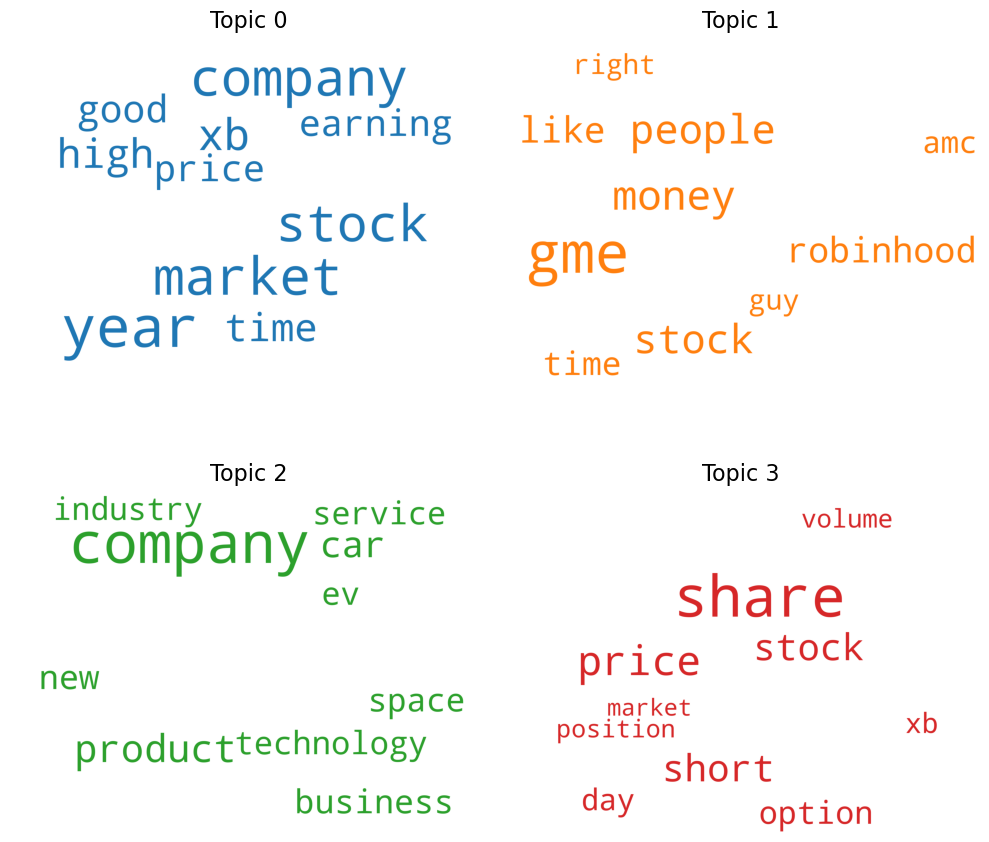

In [15]:
# Extracting a list of colors from the TABLEAU_COLORS dictionary
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

# Creating a WordCloud object with specified parameters
cloud = WordCloud(stopwords=stop_words,  # Providing stopwords for the WordCloud
                  background_color='white',  # Setting background color to white
                  width=2500,  # Setting width of the WordCloud
                  height=1800,  # Setting height of the WordCloud
                  max_words=30,  # Limiting maximum number of words in the WordCloud
                  colormap='tab10',  # Setting colormap for colors
                  color_func=lambda *args, **kwargs: cols[i],  # Setting custom color function for the WordCloud
                  prefer_horizontal=1.0)  # Setting horizontal preference for word orientation

# Extracting topics from lda_model and formatting them
topics = lda_model.show_topics(formatted=False)

# Creating a subplot grid for displaying multiple WordClouds
fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

# Iterating over each subplot and displaying WordCloud for each topic
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])  # Extracting words for the current topic
    cloud.generate_from_frequencies(topic_words, max_font_size=300)  # Generating WordCloud from word frequencies
    plt.gca().imshow(cloud)  # Displaying WordCloud on current axis
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))  # Setting title for the WordCloud
    plt.gca().axis('off')  # Turning off axis for cleaner visualization

# Adjusting spacing between subplots and removing unnecessary axis
plt.subplots_adjust(wspace=0, hspace=0)  # Adjusting spacing between subplots
plt.axis('off')  # Turning off axis for the entire figure
plt.margins(x=0, y=0)  # Setting margins to zero for tighter layout
plt.tight_layout()  # Adjusting layout for better visualization
plt.show()  # Displaying the entire plot

## Word Counts of Topic Keywords

In [32]:
def plot_topic_keywords(lda_model, clean_texts):

    # Extract topics and flatten data
    topics = lda_model.show_topics(formatted=False)
    data_flat = [w for w_list in clean_texts for w in w_list]
    counter = Counter(data_flat)

    # Initialize empty list to store data
    out = []

    # Iterate over topics and their words to retrieve the weights and
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])

    # Create DataFrame from collected data
    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)

    # Define colors for each subplot
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    # Iterate over subplots
    for i, ax in enumerate(axes.flatten()):
        # Plot bar chart for word count
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')

        # Create twinx axis for importance
        ax_twin = ax.twinx()

        # Plot bar chart for word importance
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')

        # Set y-axis labels
        ax.set_ylabel('Word Count', color=cols[i])
        ax_twin.set_ylim(0, 0.050)
        ax.set_ylim(0, 10000)

        # Set title for subplot
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)

        # Hide y-axis ticks
        ax.tick_params(axis='y', left=False)

        # Rotate x-axis labels
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')

        # Add legends
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    # Adjust layout
    fig.tight_layout(w_pad=2)
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)

    # Show plot
    plt.show()

In [33]:
plot_topic_keywords(lda_model, clean_texts)

# PCA Distribution of Topics (PyLDAvis)

In [29]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.058364  0.038575       1        1  32.302725
1     -0.194376 -0.222729       2        1  29.929500
3     -0.082785  0.245822       3        1  20.866781
2      0.335526 -0.061669       4        1  16.900994, topic_info=          Term          Freq         Total Category  logprob  loglift
398      share  23964.000000  23964.000000  Default  30.0000  30.0000
395        gme  21012.000000  21012.000000  Default  29.0000  29.0000
373      price  14615.000000  14615.000000  Default  28.0000  28.0000
875      short   8531.000000   8531.000000  Default  27.0000  27.0000
63     company  16616.000000  16616.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
881       able    915.831853   2565.621805   Topic4  -5.8235   0.7477
657     future    910.977051   2871.928498   Topic4  -5.8288   0.6296
571  important    802.671179   2240.023959   Topic4  -5.9554   0.7515
393       year    815.817267  11611.977812   Topic4  -5.9391  -0.8778
814   contract    791.897368   2250.176166   Topic4  -5.9689   0.7335

[256 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
881       2  0.383143     able
881       3  0.259586     able
881       4  0.357028     able
1515      2  0.835918  account
1515      3  0.163601  account
...     ...       ...      ...
846       1  0.573834       xb
846       3  0.426094       xb
393       1  0.929730     year
393       4  0.070272     year
879       3  0.999724     yolo

[317 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])